In [1]:
# Set project directory
import os
import sys

def project_dir():
    notebook_path = %pwd
    repo_name = "nsl_kdd"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)

pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers as k_layers
from tensorflow.keras import optimizers as k_optimizers
from tensorflow.keras import callbacks as k_callbacks

from sklearn.decomposition import PCA

import time

from data_utils import load_train_test_data

# Load data

In [3]:
(X_train, X_test, Y_train, Y_test), attack_labels, categories = load_train_test_data(pwd=pwd, include_categorical=True, return_categories=True)

In [4]:
for i in categories:
    print(len(i))

3
70
11


In [5]:
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])

X.shape, Y.shape

((148517, 122), (148517, 5))

In [6]:
attack_labels

array(['DoS', 'Probe', 'R2L', 'U2R', 'normal'], dtype='<U6')

# Utils

In [7]:
def fit_model(create_model, X_train, bottleneck=10, batch_size=4096, n_epochs=100, lr_start=0.001, lr_patience=None):
    model = create_model(bottleneck, lr_start)
    
    callbacks = []
    if lr_patience is not None:
        callbacks.append(k_callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
        
    history = model.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs, callbacks=callbacks).history
    
    return history, model

def plot_history(history, title, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"loss ({history[f'loss'][-1]:0.4f})")
    plt.grid()
    plt.legend()
        
    plt.suptitle(title)
    plt.show()

In [74]:
def run_and_measure(fun, *args, **kwargs):
    start = time.time()
    retval = fun(*args, **kwargs)
    end = time.time()
    return retval, end - start

def test_autoencoder(create_model, X, n_bottleneck_list, name, batch_size=8192, n_epochs=50, train=True, lr_start=0.001, lr_patience=None, verbose=0):
    histories = {}
    models = {}

    for n_bottleneck in n_bottleneck_list:
        print(f"Starting {n_bottleneck}... ", end="")

        autoencoder_model = create_model(n_bottleneck, lr=lr_start)
        models[n_bottleneck] = autoencoder_model

        if train:
            callbacks = []
            if lr_patience is not None:
                callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=lr_patience, min_delta=0.00005))

            history, t = run_and_measure(autoencoder_model.fit, 
                                         X, 
                                         [X[:, :38], X[:, 38:41], X[:, 41:111], X[:, 111:122]],
                                         batch_size=batch_size, 
                                         verbose=verbose, 
                                         epochs=n_epochs, 
                                         callbacks=callbacks)
            print(f"{t:0.2f} s")
            history = history.history
        #     autoencoder_model.save_weights(
        #         f"model_checkpoints/{name}/{n_bottleneck}/weights"
        #     )
        #     pd.DataFrame(history).to_csv(
        #         f"model_checkpoints/{name}/{n_bottleneck}/log.csv"
        #     )
        # else:
        #     history = pd.read_csv(f"model_checkpoints/{name}/{n_bottleneck}/log.csv")
        #     autoencoder_model.load_weights(
        #         f"model_checkpoints/{name}/{n_bottleneck}/weights"
        #     )
        #     print()

        histories[n_bottleneck] = history

    return histories, models

def plot_histories(histories, title, ymax=1, print_mse=True):
    plt.figure(figsize=(12, 8))

    for n_bottleneck, history in histories.items():
        plt.plot(np.arange(1, len(history["loss"]) + 1), history["loss"], label=f"{n_bottleneck}")

    plt.ylim(0, ymax)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    for n_bottleneck, history in histories.items():
        print(f"n_bottleneck={n_bottleneck:2}: our_loss={min(history['loss']):0.6f}")

In [67]:
def mse_loss_generic(y_true, y_pred, start, stop):
    squared_difference = tf.square(y_true[:, start:stop] - y_pred[:, start:stop])
    return tf.reduce_mean(squared_difference, axis=-1)

def entropy_loss_generic(y_true, y_pred, start, stop):
    return tf.keras.losses.categorical_crossentropy(y_true[:, start:stop], y_pred[:, start:stop])

losses = [
    lambda y_true, y_pred: mse_loss_generic(y_true, y_pred, 0, 38),
    lambda y_true, y_pred: entropy_loss_generic(y_true, y_pred, 38, 41),
    lambda y_true, y_pred: entropy_loss_generic(y_true, y_pred, 41, 111),
    lambda y_true, y_pred: entropy_loss_generic(y_true, y_pred, 111, 122)
]

loss_weights = [1, 1, 1, 1]

def our_loss(y_true, y_pred):
    loss = [weight * np.mean(loss_fun(y_true, y_pred)) for loss_fun, weight in zip(losses, loss_weights)]
    return sum(loss)

# PCA

In [33]:
pca = PCA()
X_pca = pca.fit_transform(X)

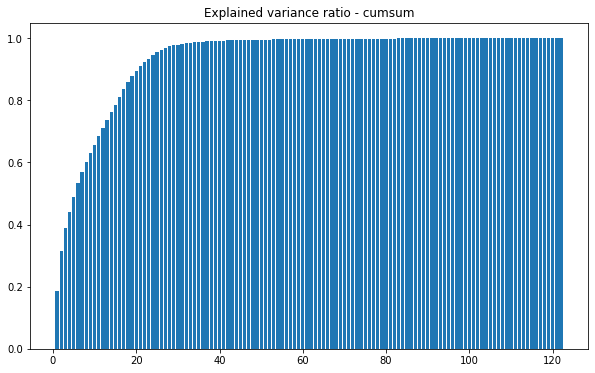

In [34]:
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(1, pca.explained_variance_ratio_.shape[0] + 1),
    pca.explained_variance_ratio_.cumsum(),
)
plt.title("Explained variance ratio - cumsum")
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error

for i in range(0, 121, 5):
    X_tmp = X_pca[:, :i] @ pca.components_[:i] + pca.mean_
    loss = our_loss(X, X_tmp)
    print(f"First {i:2} components: our_loss={loss:0.6f}")

First  0 components: our_loss=5.317275
First  5 components: our_loss=3.049264
First 10 components: our_loss=2.486582
First 15 components: our_loss=2.333414
First 20 components: our_loss=2.139834
First 25 components: our_loss=1.852492
First 30 components: our_loss=1.390955
First 35 components: our_loss=1.072340
First 40 components: our_loss=0.859784
First 45 components: our_loss=0.721096
First 50 components: our_loss=0.620129
First 55 components: our_loss=0.515811
First 60 components: our_loss=0.440175
First 65 components: our_loss=0.371027
First 70 components: our_loss=0.279958
First 75 components: our_loss=0.213533
First 80 components: our_loss=0.159645
First 85 components: our_loss=0.111033
First 90 components: our_loss=0.064626
First 95 components: our_loss=0.035574
First 100 components: our_loss=0.022325
First 105 components: our_loss=0.006678
First 110 components: our_loss=0.000758
First 115 components: our_loss=0.000062
First 120 components: our_loss=0.000000


# Model v1

In [15]:
def create_model_v1(bottleneck=10, lr=0.001):
    inputs = k_layers.Input(122)
    
    x = k_layers.Dense(bottleneck)(inputs)
    
    output_1 = k_layers.Dense(38)(x)
    output_2 = k_layers.Dense(3, activation='softmax')(x)
    output_3 = k_layers.Dense(70, activation='softmax')(x)
    output_4 = k_layers.Dense(11, activation='softmax')(x)
    
    model = tf.keras.Model(
        inputs=inputs,
        outputs=[output_1, output_2, output_3, output_4]
    )
        
    model.compile(
        k_optimizers.Adam(learning_rate=lr), 
        loss=['mse', 'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
        loss_weights=[1, 1, 1, 1]
    )
        
    return model

# create_model_v1().summary()

In [72]:
N_BOTTLENECK = [2, 4, 8, 16]
histories_v1, models_v1 = test_autoencoder(create_model_v1, X, N_BOTTLENECK, 'model_v1', n_epochs=400, lr_start=0.004, lr_patience=20, verbose=0)

Starting 2... 58.01 s
Starting 4... 58.15 s
Starting 8... 56.15 s
Starting 16... 60.36 s


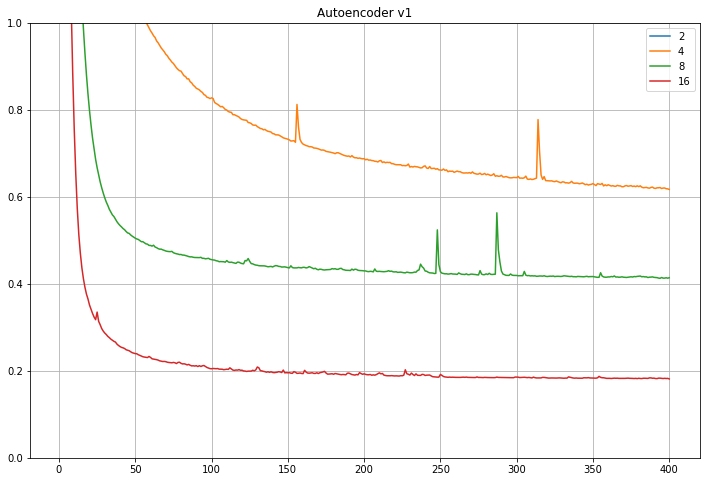

n_bottleneck= 2: mse=1.333433
n_bottleneck= 4: mse=0.617166
n_bottleneck= 8: mse=0.412747
n_bottleneck=16: mse=0.181358


In [73]:
plot_histories(histories_v1, "Autoencoder v1")

# Model v2

In [75]:
def create_model_v2(bottleneck=10, lr=0.001):
    inputs = k_layers.Input(122)
    
    x = k_layers.Dense(30, activation='relu')(inputs)
    x = k_layers.Dense(bottleneck)(x)
    x = k_layers.Dense(30, activation='relu')(x)
    
    output_1 = k_layers.Dense(38)(x)
    output_2 = k_layers.Dense(3, activation='softmax')(x)
    output_3 = k_layers.Dense(70, activation='softmax')(x)
    output_4 = k_layers.Dense(11, activation='softmax')(x)
    
    model = tf.keras.Model(
        inputs=inputs,
        outputs=[output_1, output_2, output_3, output_4]
    )
        
    model.compile(
        k_optimizers.Adam(learning_rate=lr), 
        loss=['mse', 'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
        loss_weights=[1, 1, 1, 1]
    )
        
    return model

# create_model_v2().summary()

In [76]:
N_BOTTLENECK = [2, 4, 8, 16]
histories_v2, models_v2 = test_autoencoder(create_model_v2, X, N_BOTTLENECK, 'model_v2', n_epochs=400, lr_start=0.002, lr_patience=20)

Starting 2... 63.80 s
Starting 4... 60.59 s
Starting 8... 60.77 s
Starting 16... 61.42 s


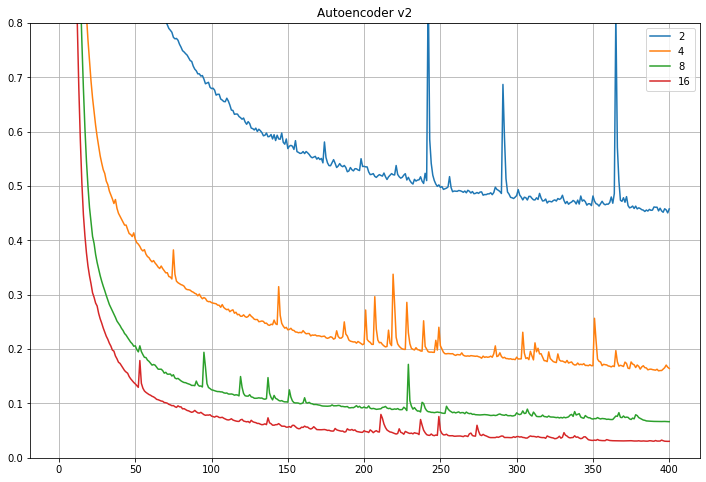

n_bottleneck= 2: our_loss=0.450554
n_bottleneck= 4: our_loss=0.159947
n_bottleneck= 8: our_loss=0.066428
n_bottleneck=16: our_loss=0.030237


In [77]:
plot_histories(histories_v2, "Autoencoder v2", ymax=0.8)

# Model v3

In [78]:
def create_model_v3(bottleneck=10, lr=0.001):
    inputs = k_layers.Input(122)
    
    x = k_layers.Dense(120, activation='relu')(inputs)
    x = k_layers.Dense(60, activation='relu')(x)
    x = k_layers.Dense(30, activation='relu')(x)
    x = k_layers.Dense(bottleneck)(x)
    x = k_layers.Dense(30, activation='relu')(x)
    x = k_layers.Dense(60, activation='relu')(x)
    x = k_layers.Dense(120, activation='relu')(x)
    
    output_1 = k_layers.Dense(38)(x)
    output_2 = k_layers.Dense(3, activation='softmax')(x)
    output_3 = k_layers.Dense(70, activation='softmax')(x)
    output_4 = k_layers.Dense(11, activation='softmax')(x)
    
    model = tf.keras.Model(
        inputs=inputs,
        outputs=[output_1, output_2, output_3, output_4]
    )
        
    model.compile(
        k_optimizers.Adam(learning_rate=lr), 
        loss=['mse', 'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
        loss_weights=[1, 1, 1, 1]
    )
        
    return model

In [79]:
N_BOTTLENECK = [2, 4, 8, 16]
histories_v3, models_v3 = test_autoencoder(create_model_v3, X, N_BOTTLENECK, 'model_v3', n_epochs=400, lr_start=0.002, lr_patience=20)

Starting 2... 74.08 s
Starting 4... 74.54 s
Starting 8... 74.72 s
Starting 16... 73.40 s


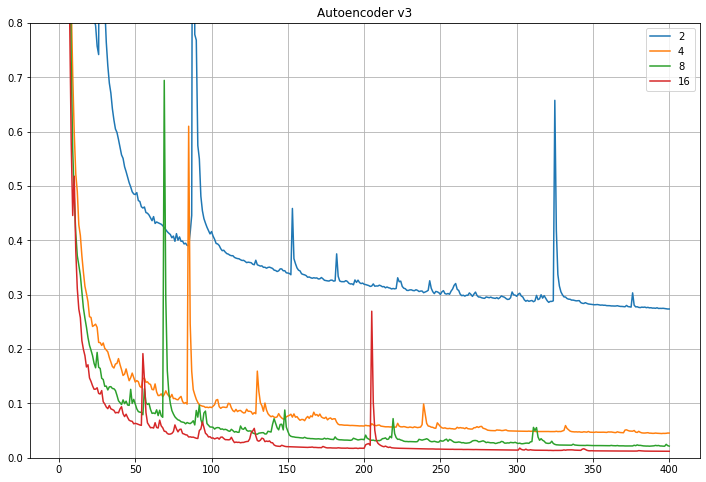

n_bottleneck= 2: our_loss=0.273730
n_bottleneck= 4: our_loss=0.044615
n_bottleneck= 8: our_loss=0.021340
n_bottleneck=16: our_loss=0.012001


In [80]:
plot_histories(histories_v3, "Autoencoder v3", ymax=0.8)